### Learning sparse coding representation by experimenting with MNIST dataset. 

##### I am following Hugo Larochell's video series on sparse coding: https://www.youtube.com/watch?v=7a0_iEruGoM

#### First loading MNIST dataset. I am using this python script from: https://github.com/hsjeong5/MNIST-for-Numpy

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import mnist
import numpy as np

In [2]:
mnist.init()

Download complete.
Save complete.


In [3]:
type(mnist)

module

In [4]:
x_train, t_train, x_test, t_test = mnist.load()

In [5]:
pd.DataFrame(x_train).head()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
pd.DataFrame(t_train).head()

,0
0,5
1,0
2,4
3,1
4,9


In [7]:
len(t_train)

60000

In [8]:
def plot_samples(image_array, num_samples_x, num_samples_y):
    f, axarr = plt.subplots(num_samples_x,num_samples_y)

    n=0
    
    for i in range(0,num_samples_x):
        for j in range(0,num_samples_y):
            img = image_array[n,:].reshape(28,28) # 28x28 because of MNIST size
            axarr[i,j].imshow(img,cmap='gray')
            axarr[i,j].axis('off')
            n+=1

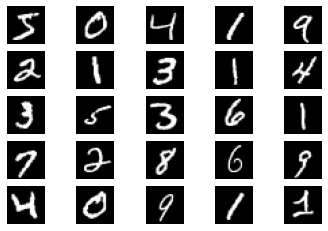

In [9]:
plot_samples(x_train,5,5)

In [10]:
a = np.zeros((10,10))
k=0
for i in range(0,10):
    for j in range(0,10):
        a[i][j] = t_train[k]
        k+=1

In [11]:
a

array([[5., 0., 4., 1., 9., 2., 1., 3., 1., 4.],
       [3., 5., 3., 6., 1., 7., 2., 8., 6., 9.],
       [4., 0., 9., 1., 1., 2., 4., 3., 2., 7.],
       [3., 8., 6., 9., 0., 5., 6., 0., 7., 6.],
       [1., 8., 7., 9., 3., 9., 8., 5., 9., 3.],
       [3., 0., 7., 4., 9., 8., 0., 9., 4., 1.],
       [4., 4., 6., 0., 4., 5., 6., 1., 0., 0.],
       [1., 7., 1., 6., 3., 0., 2., 1., 1., 7.],
       [9., 0., 2., 6., 7., 8., 3., 9., 0., 4.],
       [6., 7., 4., 6., 8., 0., 7., 8., 3., 1.]])

#### ZCA whitening the values
Before running a sparse coding algorithm, it is beneficial to remove "obvious" structure from the data. 

- Normalize such that mean is 0 and covariance is the identity
- This will remove the 1st and 2dn order statistical structure.


###### Running ZCA with all the training data causes kernel to die. Need to find out another way, doing it in batch definitely messes up the results of whitening.

In [12]:
def zca_whitening_matrix(X):
    """
    Function to compute ZCA whitening matrix (aka Mahalanobis whitening).
    INPUT:  X: [M x N] matrix.
        Rows: Variables
        Columns: Observations
    OUTPUT: ZCAMatrix: [M x M] matrix
    """
    # Covariance matrix [column-wise variables]: Sigma = (X-mu)' * (X-mu) / N
    sigma = np.cov(X, rowvar=True) # [M x M]
    # Singular Value Decomposition. X = U * np.diag(S) * V
    U,S,V = np.linalg.svd(sigma)
        # U: [M x M] eigenvectors of sigma.
        # S: [M x 1] eigenvalues of sigma.
        # V: [M x M] transpose of U
    # Whitening constant: prevents division by zero
    epsilon = 1e-5
    # ZCA Whitening matrix: U * Lambda * U'
    ZCAMatrix = np.dot(U, np.dot(np.diag(1.0/np.sqrt(S + epsilon)), U.T)) # [M x M]
    return ZCAMatrix

In [13]:
ZCA_mat = zca_whitening_matrix(x_train[0:1000])
ZCA_whitened = np.dot(ZCA_mat, x_train[0:1000]) # project X onto the ZCAMatrix


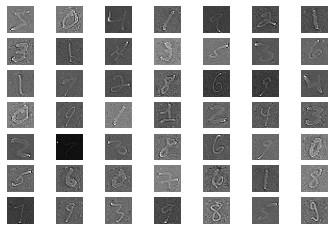

In [14]:
plot_samples(ZCA_whitened, 7,7)

### Using ISTA to infer the sparse codes

In [28]:
convergenceThreshold = 0.005
sparsityTerm = 0.5
maxIterations = 10000
learningRate = 0.005

def shrink(a,b):
    sign = [1 if x>0 else -1 for x in a]
    shrinkedValue = 

def ISTA(X, h, D):
    prevObjectiveFunction = 0
    i = 0
    while True:
        # Iterations i
        i +=1
        
        Y = h@D
        objectiveFunction = 0.5 * np.sum((X-Y)**2) + sparsityTerm * np.sum(np.absolute(h))
        diffObjectiveFunction = abs(objectiveFunction - prevObjectiveFunction)
        
        # Break from loop once the ISTA converges
        if(diffObjectiveFunction < convergenceThreshold or i > maxIterations):
            break
        
        prevObjectiveFunction = objectiveFunction

        h = h - learningRate * ((Y-X)@ D.T)
        h = shrink(h, learningRate * sparsityTerm)
        
    print(h, X, Y, objectiveFunction, i, diffObjectiveFunction)
    
    return h

In [29]:
ISTA(X, h, D)

NameError: name 'shrink' is not defined

In [218]:
sparsityTerm

0.5

# Scrap below

In [20]:
D=np.array([[0,1,1,
             1,0,0,
            1,1,1],
            
            [2,2,2,
             2,2,2,
            2,2,2]
            ]
           )
D

array([[0, 1, 1, 1, 0, 0, 1, 1, 1],
       [2, 2, 2, 2, 2, 2, 2, 2, 2]])

In [21]:
X=np.array([[10,25,33,
             42,51,68,
            36,88,92]]
           )
X.shape

(1, 9)

In [22]:
h = np.array([[0, 0]])
h.shape

(1, 2)

In [23]:
Y = h@D
Y-X
print((Y-X).shape)
print(D.T.shape)

(1, 9)
(9, 2)


In [46]:
a = np.array([[ 5, 1 ,3], 
              [ 1, 1 ,1],
              [ 1, 2, 1]])
b = np.array([1, 2, 3])
a.dot(b)

array([16,  6,  8])

In [71]:
j = np.array([[ -5, 1 ,-3], 
              [ 1, 1 ,1],
              [ 1, -2, 1]])

In [72]:
np.absolute(j)

array([[5, 1, 3],
       [1, 1, 1],
       [1, 2, 1]])

In [73]:
b

array([1, 2])

In [76]:
sign = [1 if x>=0 else -1 for x in b]

In [77]:
sign

[1, 1]

In [88]:
shrink(b, 1)

array([0, 1])

In [83]:
np.clip(j, 0,None)

array([[0, 1, 0],
       [1, 1, 1],
       [1, 0, 1]])